# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import os
import shutil

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Create a Spark session

spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read in sparkify dataset

#EVENT_DATA = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
EVENT_DATA = 'mini_sparkify_event_data.json'

df = spark.read.json(EVENT_DATA)
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
# create a view to use with your SQL queries

df.createOrReplaceTempView('user_log')

In [8]:
spark.sql('''
    SELECT DISTINCT userId
    FROM user_log
    ORDER BY userId
    '''
    ).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
spark.sql('''
    SELECT DISTINCT page
    FROM user_log
    WHERE userId = ''
    '''
    ).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



The empty string user id most likely refer to users who have not signed up yet or who are signed out and are about to log in therefore we can remove these records.

In [10]:
clean_user_log = spark.sql('''
    SELECT *
    FROM user_log
    WHERE userId != ''
    '''
    )

clean_user_log.createOrReplaceTempView('clean_user_log')

In [11]:
spark.sql('''
    SELECT *
    FROM clean_user_log
    WHERE userId = ''
        OR sessionId = ''
    '''
    ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Let's have a closer look at some categorical variables:
- artist
- auth
- gender
- level
- location
- method
- page
- song
- status
- userAgent

In [12]:
# Based on https://github.com/mwaskom/seaborn/issues/1582

def show_annotation_barplot(df, titolo, x_label, y_label):
    '''
    Show a barplot with annotation
    Input:
        df (dataframe): Input dataframe
        titolo (str): title for the barplot
        x_label (str): x axis label
        y_label (str): y axis label
    Output:
        None
    '''
    plt.title(titolo)
    barplot = sns.barplot(x = x_label, y = y_label, data = df, palette = 'muted')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    plt.show()

In [13]:
spark.sql('''
    SELECT DISTINCT artist
    FROM clean_user_log
    '''
    ).show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [14]:
spark.sql('''
    SELECT DISTINCT auth
    FROM clean_user_log
    '''
    ).show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



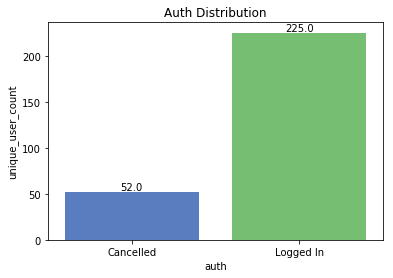

In [15]:
df_auth_distribution = spark.sql('''
    SELECT auth
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM clean_user_log
    GROUP BY auth
    '''
    ).toPandas()

show_annotation_barplot(df_auth_distribution, 'Auth Distribution', 'auth', 'unique_user_count')

In [16]:
spark.sql('''
    SELECT DISTINCT gender
    FROM clean_user_log
    '''
    ).show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



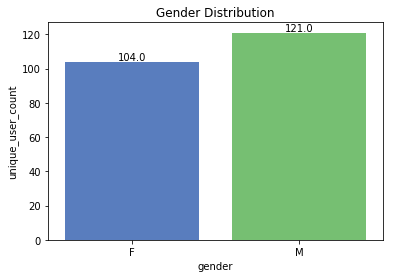

In [17]:
df_gender_distribution = spark.sql('''
    SELECT gender
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM clean_user_log
    GROUP BY gender
    '''
    ).toPandas()

show_annotation_barplot(df_gender_distribution, 'Gender Distribution', 'gender', 'unique_user_count')

In [18]:
spark.sql('''
    SELECT DISTINCT level
    FROM clean_user_log
    '''
    ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



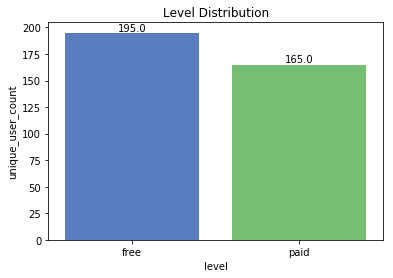

In [19]:
df_level_distribution = spark.sql('''
    SELECT level
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM clean_user_log
    GROUP BY level
    '''
    ).toPandas()

show_annotation_barplot(df_level_distribution, 'Level Distribution', 'level', 'unique_user_count')

In [20]:
spark.sql('''
    SELECT DISTINCT location
    FROM clean_user_log
    '''
    ).show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [21]:
spark.sql('''
    SELECT DISTINCT method
    FROM clean_user_log
    '''
    ).show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [22]:
spark.sql('''
    SELECT DISTINCT page
    FROM clean_user_log
    '''
    ).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [23]:
df_page_distribution = spark.sql('''
    SELECT page
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM clean_user_log
    GROUP BY page
    '''
    ).toPandas()

df_page_distribution

,page,unique_user_count
0,Cancel,52
1,Submit Downgrade,49
2,Thumbs Down,203
3,Home,223
4,Downgrade,154
5,Roll Advert,207
6,Logout,213
7,Save Settings,132
8,Cancellation Confirmation,52
9,About,155


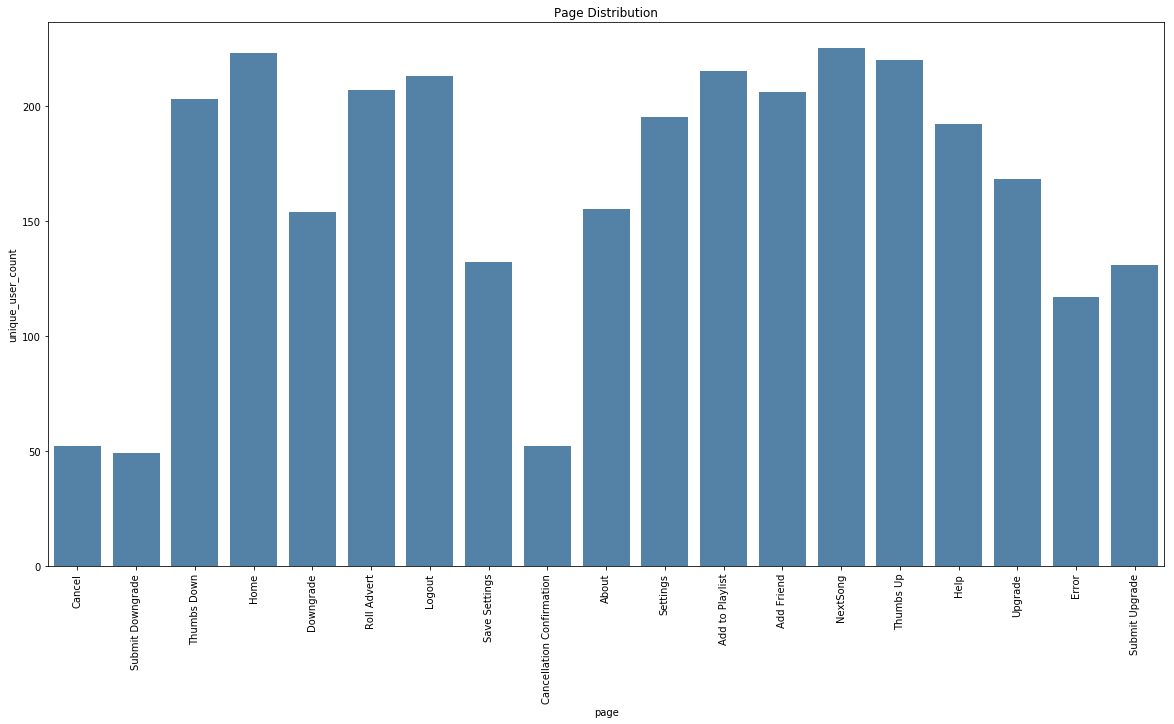

In [24]:
plt.figure(figsize = (20, 10)) 
plt.title('Page Distribution')
sns.barplot(x = 'page', y = 'unique_user_count', data = df_page_distribution, color = 'steelblue')
plt.xticks(rotation = 90)
plt.show()

In [25]:
spark.sql('''
    SELECT DISTINCT song
    FROM clean_user_log
    '''
    ).show()

+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
|The Fun Lovin' Cr...|
|Turn Your Lights ...|
|          Growing Up|
|          Positivity|
|         Miracle Man|
|        I'm The Drug|
|I've Just Seen A ...|
|            Anna May|
|All The Things Sh...|
|    Blue Suede Shoes|
+--------------------+
only showing top 20 rows



In [26]:
spark.sql('''
    SELECT DISTINCT status
    FROM clean_user_log
    '''
    ).show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [27]:
spark.sql('''
    SELECT DISTINCT userAgent
    FROM clean_user_log
    '''
    ).show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



Let's see the the hourly, daily and monthly activity distribution of the users:

In [28]:
get_datetime = udf(lambda timestamp: dt.datetime.fromtimestamp(timestamp / 1000.0).isoformat().replace('T', ' '))
get_year = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).year)
get_month = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).month)
get_week = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).isocalendar()[1])
get_day = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).day)
get_hour = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).hour)

spark.udf.register('get_datetime', get_datetime)
spark.udf.register('get_year', get_year)
spark.udf.register('get_month', get_month)
spark.udf.register('get_week', get_week)
spark.udf.register('get_day', get_day)
spark.udf.register('get_hour', get_hour)

user_page_datetime = spark.sql('''
    SELECT userId
        , registration AS timestamp_registration
        , get_datetime(registration) AS datetime_registration
        , page
        , ts AS timestamp_page
        , get_datetime(ts) AS datetime_page
        , CAST(get_year(ts) AS INT) AS year
        , CAST(get_month(ts) AS INT) AS month
        , CAST(get_week(ts) AS INT) AS week
        , CAST(get_day(ts) AS INT) AS day
        , CAST(get_hour(ts) AS INT) AS hour
    FROM clean_user_log
    '''
    )

user_page_datetime.createOrReplaceTempView('user_page_datetime')

In [29]:
user_page_datetime.show(20, False)

+------+----------------------+---------------------+---------------+--------------+-------------------+----+-----+----+---+----+
|userId|timestamp_registration|datetime_registration|page           |timestamp_page|datetime_page      |year|month|week|day|hour|
+------+----------------------+---------------------+---------------+--------------+-------------------+----+-----+----+---+----+
|30    |1538173362000         |2018-09-28 22:22:42  |NextSong       |1538352117000 |2018-10-01 00:01:57|2018|10   |40  |1  |0   |
|9     |1538331630000         |2018-09-30 18:20:30  |NextSong       |1538352180000 |2018-10-01 00:03:00|2018|10   |40  |1  |0   |
|30    |1538173362000         |2018-09-28 22:22:42  |NextSong       |1538352394000 |2018-10-01 00:06:34|2018|10   |40  |1  |0   |
|9     |1538331630000         |2018-09-30 18:20:30  |NextSong       |1538352416000 |2018-10-01 00:06:56|2018|10   |40  |1  |0   |
|30    |1538173362000         |2018-09-28 22:22:42  |NextSong       |1538352676000 |2018-1

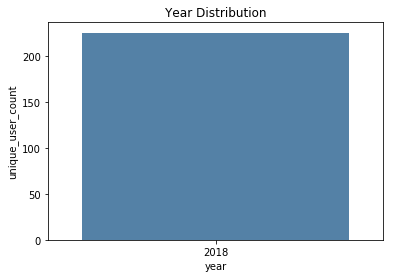

In [30]:
df_year_distribution = spark.sql('''
    SELECT year
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    GROUP BY year
    '''
    ).toPandas()

plt.title('Year Distribution')
sns.barplot(x = 'year', y = 'unique_user_count', data = df_year_distribution, color = 'steelblue')
plt.show()

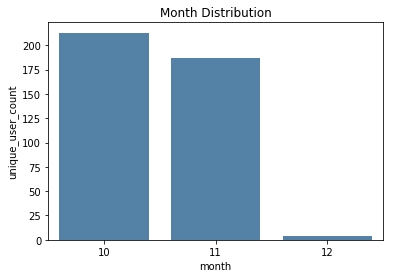

In [31]:
df_month_distribution = spark.sql('''
    SELECT month
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    GROUP BY month
    '''
    ).toPandas()

plt.title('Month Distribution')
sns.barplot(x = 'month', y = 'unique_user_count', data = df_month_distribution, color = 'steelblue')
plt.show()

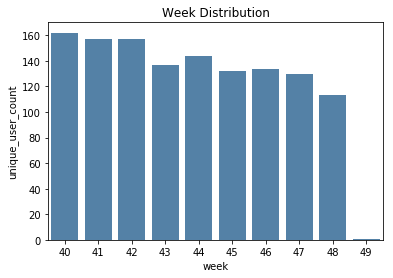

In [32]:
df_week_distribution = spark.sql('''
    SELECT week
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    GROUP BY week
    '''
    ).toPandas()

plt.title('Week Distribution')
sns.barplot(x = 'week', y = 'unique_user_count', data = df_week_distribution, color = 'steelblue')
plt.show()

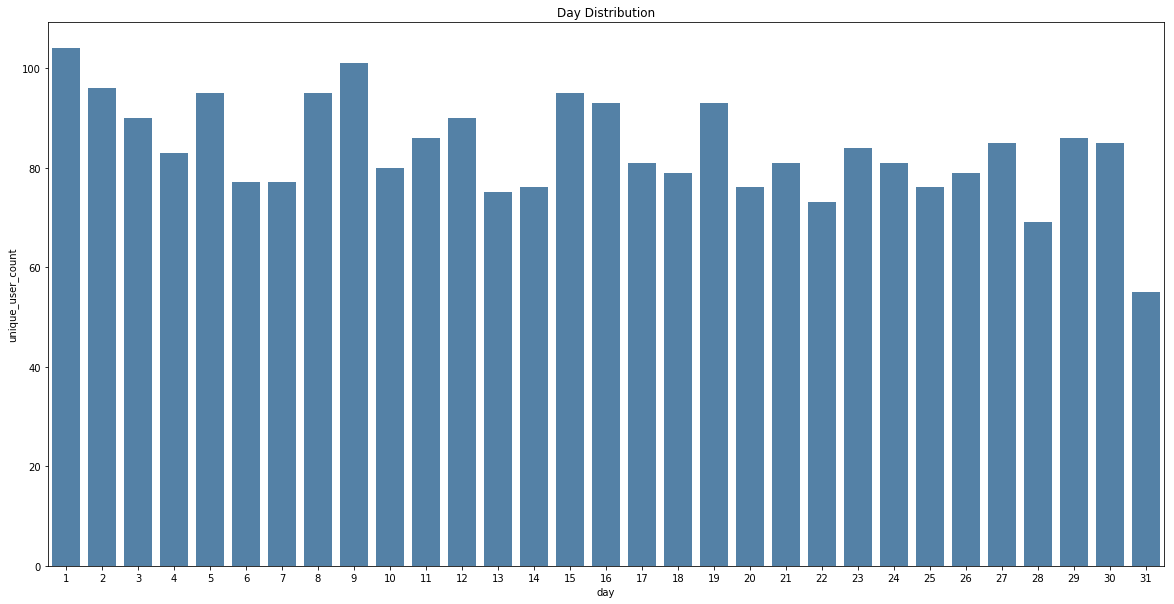

In [33]:
df_day_distribution = spark.sql('''
    SELECT day
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    GROUP BY day
    ORDER BY day ASC
    '''
    ).toPandas()

plt.figure(figsize = (20, 10)) 
plt.title('Day Distribution')
sns.barplot(x = 'day', y = 'unique_user_count', data = df_day_distribution, color = 'steelblue')
plt.show()

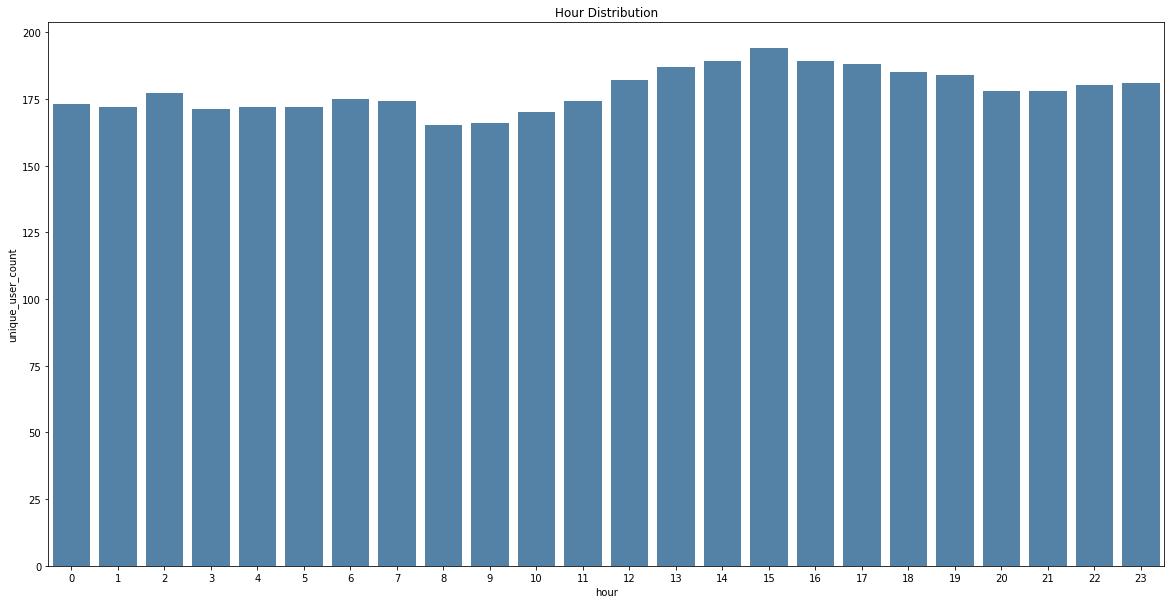

In [34]:
df_hour_distribution = spark.sql('''
    SELECT hour
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    GROUP BY hour
    ORDER BY hour ASC
    '''
    ).toPandas()

plt.figure(figsize = (20, 10)) 
plt.title('Hour Distribution')
sns.barplot(x = 'hour', y = 'unique_user_count', data = df_hour_distribution, color = 'steelblue')
plt.show()

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [35]:
churn_clean_user_log = spark.sql('''
    SELECT CUL.*
        , CASE
            WHEN CCUL.userId IS NULL THEN 0
            ELSE 1
          END AS churn
    FROM clean_user_log CUL
    LEFT JOIN 
    (
        SELECT userId 
        FROM clean_user_log
        WHERE page = 'Cancellation Confirmation'
    ) CCUL
        ON CUL.userId = CCUL.userId
    '''
    )

churn_clean_user_log.createOrReplaceTempView('churn_clean_user_log')

In [36]:
spark.sql('''
    SELECT *
    FROM churn_clean_user_log
    '''
    ).show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|
|Francesca Battist...|Logged In| Darianna|     F|            1|Carpenter|196.544

In [37]:
churned_clean_user_log = spark.sql('''
    SELECT *
    FROM churn_clean_user_log
    WHERE churn = 1
    '''
    )

churned_clean_user_log.createOrReplaceTempView('churned_clean_user_log')

In [38]:
spark.sql('''
    SELECT COUNT(DISTINCT userId)
    FROM churned_clean_user_log
    '''
    ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [39]:
no_churned_clean_user_log = spark.sql('''
    SELECT *
    FROM churn_clean_user_log
    WHERE churn = 0
    '''
    )

no_churned_clean_user_log.createOrReplaceTempView('no_churned_clean_user_log')

In [40]:
spark.sql('''
    SELECT COUNT(DISTINCT userId)
    FROM no_churned_clean_user_log
    '''
    ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   173|
+----------------------+



In [41]:
spark.sql('''
    SELECT userId
    FROM no_churned_clean_user_log
    
    INTERSECT
    
    SELECT userId
    FROM churned_clean_user_log    
    '''
    ).show()

+------+
|userId|
+------+
+------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [42]:
df_churn_distribution = spark.sql('''
    SELECT churn
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM no_churned_clean_user_log
    GROUP BY churn
    
    UNION ALL
    
    SELECT churn
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM churned_clean_user_log
    GROUP BY churn
    ''').toPandas()

#show_annotation_barplot(df_churn_distribution, 'Churn Distribution', 'churn', 'unique_user_count')
df_churn_distribution

,churn,unique_user_count
0,0,173
1,1,52


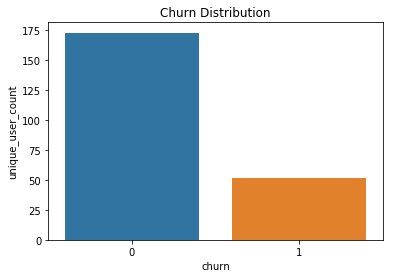

In [43]:
plt.title('Churn Distribution')
sns.barplot(x = 'churn', y = 'unique_user_count', data = df_churn_distribution)
plt.show()

Let's peek at some actions of a user who churned and a user who didn't. Let's peek **userId** 51 for example of the churn users and 124 for example for not churn users:

In [44]:
spark.sql('''
    SELECT ts
        , page
        , churn
    FROM churn_clean_user_log
    WHERE userId = 51
        AND page NOT IN ('NextSong')
    ORDER BY ts DESC
    '''
    ).show(100)

+-------------+--------------------+-----+
|           ts|                page|churn|
+-------------+--------------------+-----+
|1539761972000|Cancellation Conf...|    1|
|1539761830000|              Cancel|    1|
|1539761829000|            Settings|    1|
|1539759213000|           Thumbs Up|    1|
|1539756964000|         Thumbs Down|    1|
|1539756515000|                Home|    1|
|1539752986000|           Thumbs Up|    1|
|1539752512000|                Home|    1|
|1539747830000|           Thumbs Up|    1|
|1539747231000|           Thumbs Up|    1|
|1539744275000|         Thumbs Down|    1|
|1539744065000|           Thumbs Up|    1|
|1539740049000|           Downgrade|    1|
|1539737903000|           Thumbs Up|    1|
|1539734509000|           Thumbs Up|    1|
|1539733598000|           Thumbs Up|    1|
|1539733361000|         Thumbs Down|    1|
|1539731022000|     Add to Playlist|    1|
|1539730996000|           Thumbs Up|    1|
|1539729913000|     Add to Playlist|    1|
|1539729100

In [45]:
spark.sql('''
    SELECT ts
        , page
        , churn
    FROM churn_clean_user_log
    WHERE userId = 124
        AND page NOT IN ('NextSong')
    ORDER BY ts DESC
    '''
    ).show(100)

+-------------+---------------+-----+
|           ts|           page|churn|
+-------------+---------------+-----+
|1543590766000|           Home|    0|
|1543520886000|           Home|    0|
|1543520842000|           Home|    0|
|1543520718000|         Logout|    0|
|1543517487000|      Thumbs Up|    0|
|1543517334000|      Thumbs Up|    0|
|1543516712000|    Thumbs Down|    0|
|1543515887000|          Error|    0|
|1543514977000|     Add Friend|    0|
|1543514976000|     Add Friend|    0|
|1543514975000|           Home|    0|
|1543514935000|      Downgrade|    0|
|1543511835000|Add to Playlist|    0|
|1543505458000|      Thumbs Up|    0|
|1543505268000|           Home|    0|
|1543500965000|Add to Playlist|    0|
|1543499324000|      Thumbs Up|    0|
|1543498715000|      Thumbs Up|    0|
|1543497722000|      Thumbs Up|    0|
|1543495828000|      Thumbs Up|    0|
|1543494374000|      Thumbs Up|    0|
|1543375549000|           Home|    0|
|1543375430000|         Logout|    0|
|15433733250

As expected the last action for the user who churned is `Cancellation Confirmation`. 

Let's compare the distribution of the useful categorical variables between churned and non-churned users:

In [46]:
df_churn_auth_distribution = spark.sql('''
    SELECT 0 AS churn
        , auth
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM no_churned_clean_user_log
    GROUP BY auth
    
    UNION ALL
    
    SELECT 1 AS churn
        , auth
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM churned_clean_user_log
    GROUP BY auth
    ''').toPandas()

df_churn_auth_distribution

,churn,auth,unique_user_count
0,0,Logged In,173
1,1,Cancelled,52
2,1,Logged In,52


In [47]:
def percentual_unique_user(df):
    '''
    Returns a dataframe with also the 'percentual_unique_user' column
    Input:
        df (DataFrame): Input dataframe with 'unique_user' column
        
    Output:
        df (DataFrame): dataframe with 'percentual_unique_user' column
    '''
    total_no_churned = sum(df['unique_user_count'][df['churn'] == 0])
    total_churned = sum(df['unique_user_count'][df['churn'] == 1])
    df['percentual_unique_user'] = np.where(df['churn'] == 0, df['unique_user_count'] / total_no_churned, df['unique_user_count'] / total_churned)
    return df

In [48]:
df_churn_auth_distribution = percentual_unique_user(df_churn_auth_distribution)
df_churn_auth_distribution

,churn,auth,unique_user_count,percentual_unique_user
0,0,Logged In,173,1.0
1,1,Cancelled,52,0.5
2,1,Logged In,52,0.5


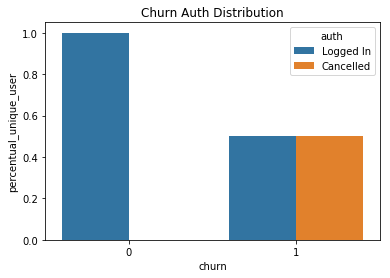

In [49]:
plt.title('Churn Auth Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'auth', data = df_churn_auth_distribution)
plt.show()

In [50]:
df_churn_gender_distribution = spark.sql('''
    SELECT 0 AS churn
        , gender
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM no_churned_clean_user_log
    GROUP BY gender
    
    UNION ALL
    
    SELECT 1 AS churn
        , gender
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM churned_clean_user_log
    GROUP BY gender
    ''').toPandas()

df_churn_gender_distribution

,churn,gender,unique_user_count
0,0,F,84
1,0,M,89
2,1,F,20
3,1,M,32


In [51]:
df_churn_gender_distribution = percentual_unique_user(df_churn_gender_distribution)
df_churn_gender_distribution

,churn,gender,unique_user_count,percentual_unique_user
0,0,F,84,0.485549
1,0,M,89,0.514451
2,1,F,20,0.384615
3,1,M,32,0.615385


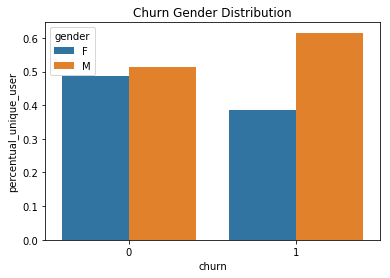

In [52]:
plt.title('Churn Gender Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'gender', data = df_churn_gender_distribution)
plt.show()

In [53]:
df_churn_level_distribution = spark.sql('''
    SELECT 0 AS churn
        , level
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM no_churned_clean_user_log
    GROUP BY level
    
    UNION ALL
    
    SELECT 1 AS churn
        , level
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM churned_clean_user_log
    GROUP BY level
    ''').toPandas()

df_churn_level_distribution

,churn,level,unique_user_count
0,0,free,149
1,0,paid,129
2,1,free,46
3,1,paid,36


In [54]:
df_churn_level_distribution = percentual_unique_user(df_churn_level_distribution)
df_churn_level_distribution

,churn,level,unique_user_count,percentual_unique_user
0,0,free,149,0.535971
1,0,paid,129,0.464029
2,1,free,46,0.560976
3,1,paid,36,0.439024


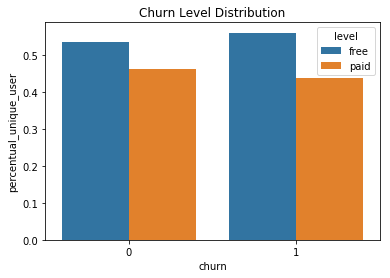

In [55]:
plt.title('Churn Level Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'level', data = df_churn_level_distribution)
plt.show()

In [56]:
df_churn_page_distribution = spark.sql('''
    SELECT 0 AS churn
        , page
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM no_churned_clean_user_log
    GROUP BY page
    
    UNION ALL
    
    SELECT 1 AS churn
        , page
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM churned_clean_user_log
    GROUP BY page
    ''').toPandas()

df_churn_page_distribution

,churn,page,unique_user_count
0,0,Submit Downgrade,40
1,0,Thumbs Down,155
2,0,Home,172
3,0,Downgrade,119
4,0,Roll Advert,157
5,0,Logout,167
6,0,Save Settings,102
7,0,About,124
8,0,Settings,152
9,0,Add to Playlist,165


In [57]:
df_churn_page_distribution = percentual_unique_user(df_churn_page_distribution)
df_churn_page_distribution

,churn,page,unique_user_count,percentual_unique_user
0,0,Submit Downgrade,40,0.017131
1,0,Thumbs Down,155,0.066381
2,0,Home,172,0.073662
3,0,Downgrade,119,0.050964
4,0,Roll Advert,157,0.067238
5,0,Logout,167,0.071520
6,0,Save Settings,102,0.043683
7,0,About,124,0.053105
8,0,Settings,152,0.065096
9,0,Add to Playlist,165,0.070664


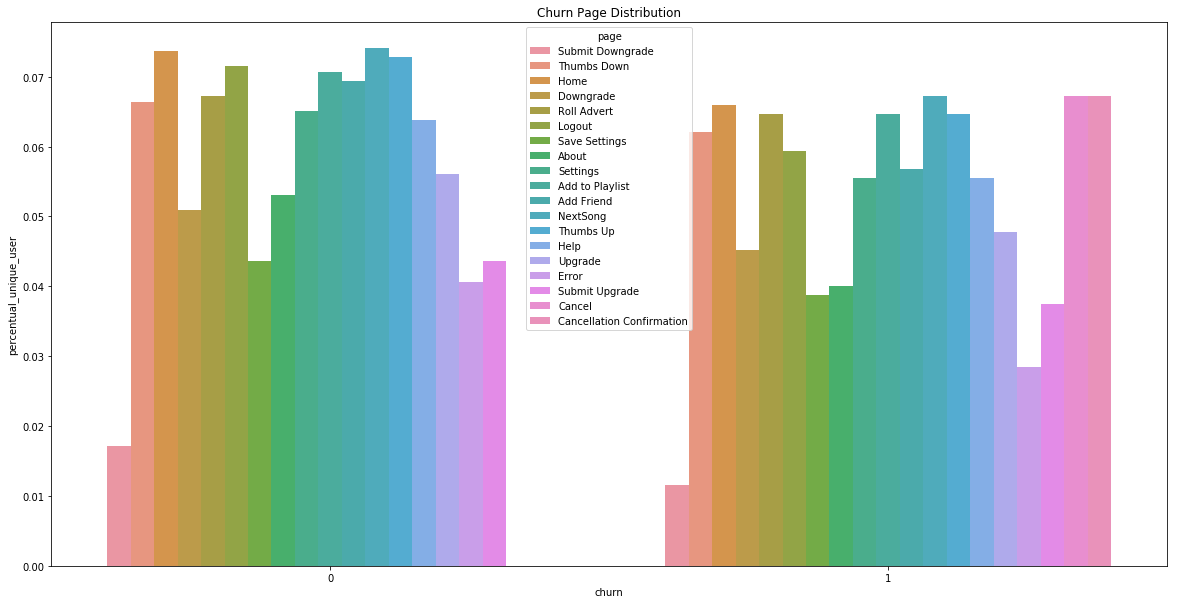

In [58]:
plt.figure(figsize = (20, 10)) 
plt.title('Churn Page Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'page', data = df_churn_page_distribution)
plt.show()

`Downgrade` and `Submit Downgrade` are not very informative for our purpose: how many times a user visit one of these pages does not seams to be relaed to the decision to visit `Cancellation Confirmation`.

Let's compare also the hourly, daily, monthly and yearly between churned and non-churned users:

In [59]:
df_churn_year_distribution = spark.sql('''
    SELECT 0 AS churn
        , year
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    GROUP BY year
    
    UNION ALL
    
    SELECT 1 AS churn
        , year
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    GROUP BY year
    ''').toPandas()

df_churn_year_distribution

,churn,year,unique_user_count
0,0,2018,173
1,1,2018,52


In [60]:
df_churn_year_distribution = percentual_unique_user(df_churn_year_distribution)
df_churn_year_distribution

,churn,year,unique_user_count,percentual_unique_user
0,0,2018,173,1.0
1,1,2018,52,1.0


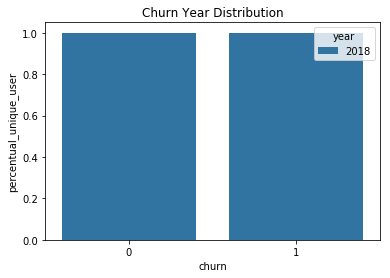

In [61]:
plt.title('Churn Year Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'year', data = df_churn_year_distribution)
plt.show()

In [62]:
df_churn_month_distribution = spark.sql('''
    SELECT 0 AS churn
        , month
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    GROUP BY month
    
    UNION ALL
    
    SELECT 1 AS churn
        , month
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    GROUP BY month
    ''').toPandas()

df_churn_month_distribution

,churn,month,unique_user_count
0,0,12,4
1,0,10,161
2,0,11,165
3,1,10,52
4,1,11,22


In [63]:
df_churn_month_distribution = percentual_unique_user(df_churn_month_distribution)
df_churn_month_distribution

,churn,month,unique_user_count,percentual_unique_user
0,0,12,4,0.012121
1,0,10,161,0.487879
2,0,11,165,0.500000
3,1,10,52,0.702703
4,1,11,22,0.297297


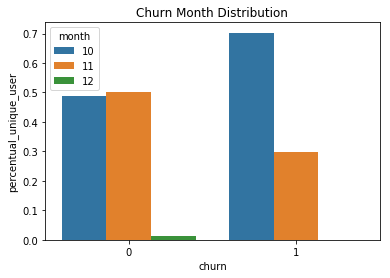

In [64]:
plt.title('Churn Month Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'month', data = df_churn_month_distribution)
plt.show()

In [65]:
df_churn_week_distribution = spark.sql('''
    SELECT 0 AS churn
        , week
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    GROUP BY week
    
    UNION ALL
    
    SELECT 1 AS churn
        , week
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    GROUP BY week
    ''').toPandas()

df_churn_week_distribution

,churn,week,unique_user_count
0,0,44,122
1,0,47,124
2,0,40,116
3,0,48,112
4,0,41,117
5,0,43,111
6,0,49,1
7,0,45,119
8,0,42,123
9,0,46,124


In [66]:
df_churn_week_distribution = percentual_unique_user(df_churn_week_distribution)
df_churn_week_distribution

,churn,week,unique_user_count,percentual_unique_user
0,0,44,122,0.114125
1,0,47,124,0.115996
2,0,40,116,0.108513
3,0,48,112,0.104771
4,0,41,117,0.109448
5,0,43,111,0.103835
6,0,49,1,0.000935
7,0,45,119,0.111319
8,0,42,123,0.115061
9,0,46,124,0.115996


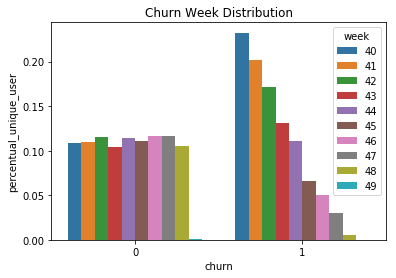

In [67]:
plt.title('Churn Week Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'week', data = df_churn_week_distribution)
plt.show()

In [68]:
df_churn_day_distribution = spark.sql('''
    SELECT 0 AS churn
        , day
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    GROUP BY day
    
    UNION ALL
    
    SELECT 1 AS churn
        , day
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    GROUP BY day
    ''').toPandas()

df_churn_day_distribution

,churn,day,unique_user_count
0,0,31,45
1,0,28,67
2,0,26,69
3,0,27,78
4,0,12,63
5,0,22,63
6,0,1,81
7,0,13,60
8,0,16,78
9,0,6,61


In [69]:
df_churn_day_distribution = percentual_unique_user(df_churn_day_distribution)
df_churn_day_distribution

,churn,day,unique_user_count,percentual_unique_user
0,0,31,45,0.021157
1,0,28,67,0.031500
2,0,26,69,0.032440
3,0,27,78,0.036671
4,0,12,63,0.029619
5,0,22,63,0.029619
6,0,1,81,0.038082
7,0,13,60,0.028209
8,0,16,78,0.036671
9,0,6,61,0.028679


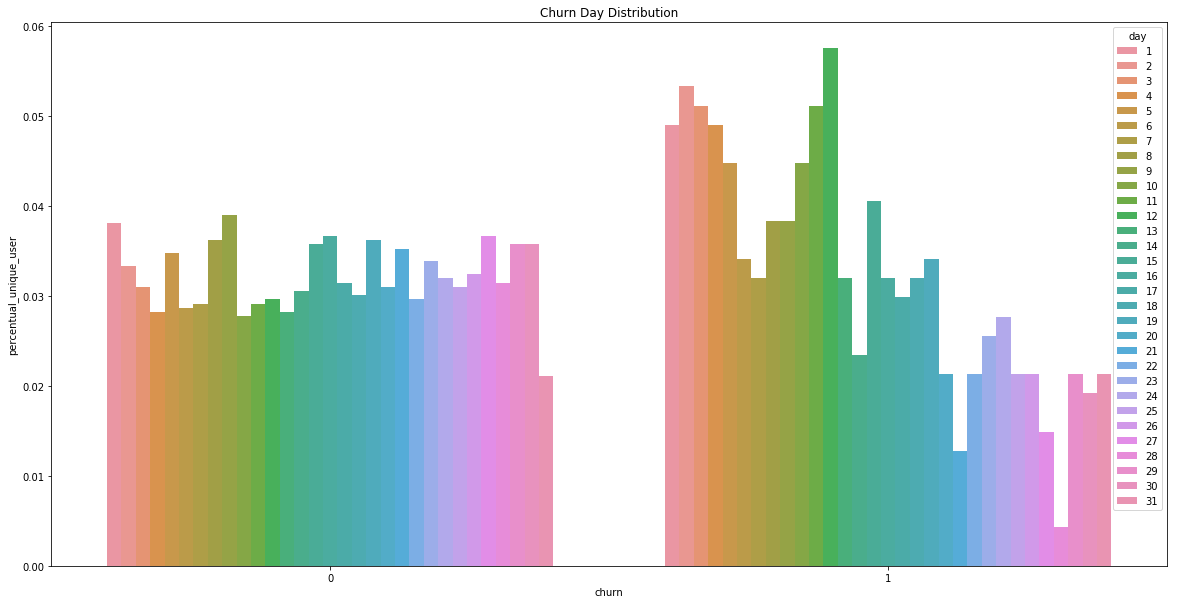

In [70]:
plt.figure(figsize = (20, 10)) 
plt.title('Churn Day Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'day', data = df_churn_day_distribution)
plt.show()

In [71]:
df_churn_hour_distribution = spark.sql('''
    SELECT 0 AS churn
        , hour
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    GROUP BY hour
    
    UNION ALL
    
    SELECT 1 AS churn
        , hour
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM user_page_datetime
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    GROUP BY hour
    ''').toPandas()

df_churn_hour_distribution

,churn,hour,unique_user_count
0,0,12,145
1,0,22,142
2,0,1,138
3,0,13,148
4,0,16,147
5,0,6,138
6,0,3,139
7,0,20,138
8,0,5,137
9,0,19,142


In [72]:
df_churn_hour_distribution = percentual_unique_user(df_churn_hour_distribution)
df_churn_hour_distribution

,churn,hour,unique_user_count,percentual_unique_user
0,0,12,145,0.042988
1,0,22,142,0.042099
2,0,1,138,0.040913
3,0,13,148,0.043878
4,0,16,147,0.043581
5,0,6,138,0.040913
6,0,3,139,0.041210
7,0,20,138,0.040913
8,0,5,137,0.040617
9,0,19,142,0.042099


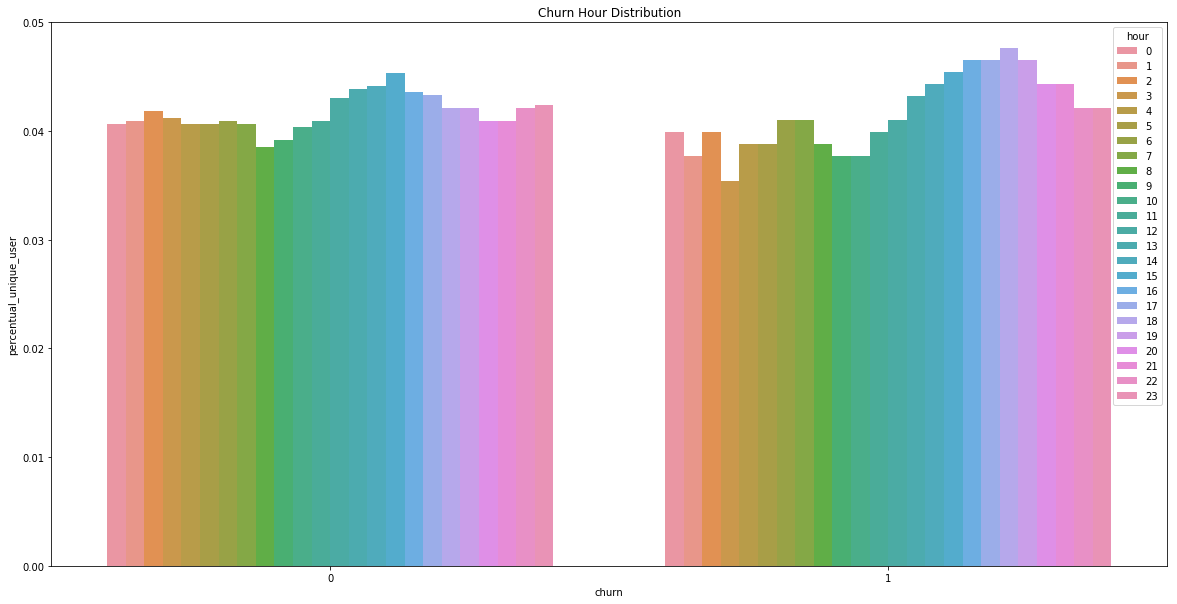

In [73]:
plt.figure(figsize = (20, 10)) 
plt.title('Churn Hour Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'hour', data = df_churn_hour_distribution)
plt.show()

None of the time-activity distribution is very informative for differentiate the churn of the users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Let's one-hot encode all the categorical features that can bu useful for us:
- gender
- level
- page

In [74]:
sql_str = ''

for feature in ['gender', 'level', 'page']:
    feature_values = spark.sql('''SELECT DISTINCT ''' + feature + ''' FROM clean_user_log''').toPandas().values.tolist()
    for item in feature_values:
        temp_str_sql = '\t, CASE WHEN ' + feature + ' = ' + "'" + str(item[0]) + "'" + ' THEN 1 ELSE 0 END AS ' + feature + '_' + str(item[0]).replace(' ', '_')
        #print(temp_str_sql)
        sql_str = sql_str + temp_str_sql + '\n'
        
print(sql_str)

	, CASE WHEN gender = 'F' THEN 1 ELSE 0 END AS gender_F
	, CASE WHEN gender = 'M' THEN 1 ELSE 0 END AS gender_M
	, CASE WHEN level = 'free' THEN 1 ELSE 0 END AS level_free
	, CASE WHEN level = 'paid' THEN 1 ELSE 0 END AS level_paid
	, CASE WHEN page = 'Cancel' THEN 1 ELSE 0 END AS page_Cancel
	, CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END AS page_Submit_Downgrade
	, CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END AS page_Thumbs_Down
	, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS page_Home
	, CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END AS page_Downgrade
	, CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END AS page_Roll_Advert
	, CASE WHEN page = 'Logout' THEN 1 ELSE 0 END AS page_Logout
	, CASE WHEN page = 'Save Settings' THEN 1 ELSE 0 END AS page_Save_Settings
	, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS page_Cancellation_Confirmation
	, CASE WHEN page = 'About' THEN 1 ELSE 0 END AS page_About
	, CASE WHEN page = 'Settings' THEN 1 ELSE 0 END AS page

In [75]:
print('''
    SELECT userId
    ''' + sql_str + '''
    FROM churn_clean_user_log
    ''')


    SELECT userId
    	, CASE WHEN gender = 'F' THEN 1 ELSE 0 END AS gender_F
	, CASE WHEN gender = 'M' THEN 1 ELSE 0 END AS gender_M
	, CASE WHEN level = 'free' THEN 1 ELSE 0 END AS level_free
	, CASE WHEN level = 'paid' THEN 1 ELSE 0 END AS level_paid
	, CASE WHEN page = 'Cancel' THEN 1 ELSE 0 END AS page_Cancel
	, CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END AS page_Submit_Downgrade
	, CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END AS page_Thumbs_Down
	, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS page_Home
	, CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END AS page_Downgrade
	, CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END AS page_Roll_Advert
	, CASE WHEN page = 'Logout' THEN 1 ELSE 0 END AS page_Logout
	, CASE WHEN page = 'Save Settings' THEN 1 ELSE 0 END AS page_Save_Settings
	, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS page_Cancellation_Confirmation
	, CASE WHEN page = 'About' THEN 1 ELSE 0 END AS page_About
	, CASE WHEN page = 'Settings' TH

In [76]:
spark.sql('''
    SELECT userId
    ''' + sql_str + '''
    FROM churn_clean_user_log
    '''
    ).show()

+------+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+--------

Let's create a view with these informations and the **churn** feature: this will be the base for our modeling dataframe

In [77]:
base_engineered_feature = spark.sql('''
    SELECT userId
        , churn
    ''' + sql_str + '''
    FROM churn_clean_user_log
    '''
    )

base_engineered_feature.createOrReplaceTempView('base_engineered_feature')

In [78]:
spark.sql('''
    SELECT *
    FROM base_engineered_feature
    '''
    ).show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

Now it is possible to aggregate all the features with **SUM** grouping by the **userId**:

In [79]:
sql_str = ''

for feature in ['gender', 'level', 'page']:
    feature_values = spark.sql('''SELECT DISTINCT ''' + feature + ''' FROM clean_user_log''').toPandas().values.tolist()
    for item in feature_values:
        temp_str_sql = '\t, SUM(' + feature + '_' + str(item[0]).replace(' ', '_') + ') AS ' + feature + '_' + str(item[0]).replace(' ', '_')
        #print(temp_str_sql)
        sql_str = sql_str + temp_str_sql + '\n'
        
print(sql_str)

	, SUM(gender_F) AS gender_F
	, SUM(gender_M) AS gender_M
	, SUM(level_free) AS level_free
	, SUM(level_paid) AS level_paid
	, SUM(page_Cancel) AS page_Cancel
	, SUM(page_Submit_Downgrade) AS page_Submit_Downgrade
	, SUM(page_Thumbs_Down) AS page_Thumbs_Down
	, SUM(page_Home) AS page_Home
	, SUM(page_Downgrade) AS page_Downgrade
	, SUM(page_Roll_Advert) AS page_Roll_Advert
	, SUM(page_Logout) AS page_Logout
	, SUM(page_Save_Settings) AS page_Save_Settings
	, SUM(page_Cancellation_Confirmation) AS page_Cancellation_Confirmation
	, SUM(page_About) AS page_About
	, SUM(page_Settings) AS page_Settings
	, SUM(page_Add_to_Playlist) AS page_Add_to_Playlist
	, SUM(page_Add_Friend) AS page_Add_Friend
	, SUM(page_NextSong) AS page_NextSong
	, SUM(page_Thumbs_Up) AS page_Thumbs_Up
	, SUM(page_Help) AS page_Help
	, SUM(page_Upgrade) AS page_Upgrade
	, SUM(page_Error) AS page_Error
	, SUM(page_Submit_Upgrade) AS page_Submit_Upgrade



In [80]:
base_engineered_feature = spark.sql('''
    SELECT userId
        , SUM(churn) AS churn
    ''' + sql_str + '''
    FROM base_engineered_feature
    GROUP BY userId
    '''
    )

base_engineered_feature.createOrReplaceTempView('base_engineered_feature')

In [81]:
spark.sql('''
    SELECT *
    FROM base_engineered_feature
    '''
    ).show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

Of course for **churn**, **gender** and **level** feature the aggregation is meanigless so let's put them in boolean form. This step could be avoided by working separatly on **page** and **gender** and **level** features. Let's keep this in mind when we will work on the real dataset beacuse of high volume of data involved every step must be efficient. For this example using a restricted datasets it is not a problem. Let's also add the total number of visited pages:

In [82]:
for feature in ['gender', 'level', 'page']:
    feature_values = spark.sql('''SELECT DISTINCT ''' + feature + ''' FROM clean_user_log''').toPandas().values.tolist()
    for item in feature_values:
         print(feature + '_' + str(item[0]).replace(' ', '_'))


gender_F
gender_M
level_free
level_paid
page_Cancel
page_Submit_Downgrade
page_Thumbs_Down
page_Home
page_Downgrade
page_Roll_Advert
page_Logout
page_Save_Settings
page_Cancellation_Confirmation
page_About
page_Settings
page_Add_to_Playlist
page_Add_Friend
page_NextSong
page_Thumbs_Up
page_Help
page_Upgrade
page_Error
page_Submit_Upgrade


In [83]:
base_engineered_feature = spark.sql('''
    SELECT userId
        , CASE WHEN Churn > 0 THEN 1 ELSE 0 END AS churn
        , CASE WHEN gender_F > 0 THEN 1 ELSE 0 END AS gender_F
        , CASE WHEN gender_M > 0 THEN 1 ELSE 0 END AS gender_M
        , CASE WHEN level_free > 0 THEN 1 ELSE 0 END AS level_free
        , CASE WHEN level_paid > 0 THEN 1 ELSE 0 END AS level_paid
        , page_Cancel
        , page_Submit_Downgrade
        , page_Thumbs_Down
        , page_Home
        , page_Downgrade
        , page_Roll_Advert
        , page_Logout
        , page_Save_Settings
        , page_Cancellation_Confirmation
        , page_About
        , page_Settings
        , page_Add_to_Playlist
        , page_Add_Friend
        , page_NextSong
        , page_Thumbs_Up
        , page_Help
        , page_Upgrade
        , page_Error
        , page_Submit_Upgrade
        , (page_Cancel + page_Submit_Downgrade + page_Thumbs_Down + page_Home + page_Downgrade + page_Roll_Advert + page_Logout + page_Save_Settings + page_Cancellation_Confirmation + page_About + page_Settings + page_Add_to_Playlist + page_Add_Friend + page_NextSong + page_Thumbs_Up + page_Help + page_Upgrade + page_Error + page_Submit_Upgrade) AS total_visited_page
    FROM base_engineered_feature 
    '''
    )

base_engineered_feature.createOrReplaceTempView('base_engineered_feature')

In [84]:
spark.sql('''
    SELECT *
    FROM base_engineered_feature
    '''
    ).show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|total_visited_page|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+------------------

Can be also intresting to evaluate:
- From how much time users are registered to the service? Is churn related to that?
- Last month activity (for churned user the cancellation is the last month before cancellation) divided in weeks
- How many artists a user listened to?

In [85]:
df_registration_distribution = spark.sql('''
    SELECT difference AS registation_days
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , MIN(datetime_registration)
            , MAX(datetime_page)
            --, DATEDIFF(MAX(datetime_page), MIN(datetime_page)) AS difference
            --, DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) AS difference
            , CAST(DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) / 10 AS INT) * 10 AS difference
        FROM user_page_datetime
        GROUP BY userId 
    )
    GROUP BY difference
    ORDER BY difference ASC
    '''
    ).toPandas()

df_registration_distribution

,registation_days,unique_user_count
0,0,3
1,10,4
2,20,11
3,30,9
4,40,14
5,50,16
6,60,39
7,70,40
8,80,21
9,90,9


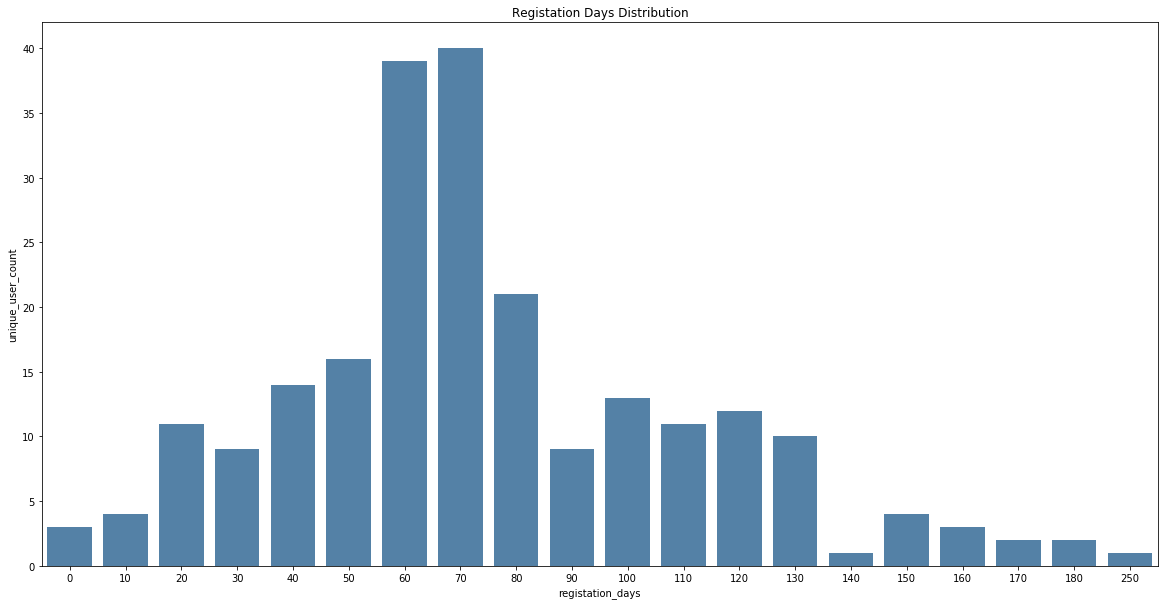

In [86]:
plt.figure(figsize = (20, 10)) 
plt.title('Registation Days Distribution')
sns.barplot(x = 'registation_days', y = 'unique_user_count', data = df_registration_distribution, color = 'steelblue')
plt.show()

In [87]:
df_churn_registration_distribution = spark.sql('''
    SELECT 0 AS churn
        , difference AS registation_days
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , MIN(datetime_registration)
            , MAX(datetime_page)
            , CAST(DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) / 10 AS INT) * 10 AS difference
        FROM user_page_datetime
        WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
        GROUP BY userId 
    ) 
    GROUP BY difference
    
    UNION ALL
    
    SELECT 1 AS churn
        , Difference AS registation_days
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , MIN(datetime_registration)
            , MAX(datetime_page)
            , CAST(DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) / 10 AS INT) * 10 AS difference
        FROM user_page_datetime
        WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
        GROUP BY userId 
    ) 
    GROUP BY difference
    ''').toPandas()

df_churn_registration_distribution

,churn,registation_days,unique_user_count
0,0,20,4
1,0,40,6
2,0,250,1
3,0,120,12
4,0,100,13
5,0,130,9
6,0,50,10
7,0,80,16
8,0,160,3
9,0,70,35


In [88]:
df_churn_registration_distribution = percentual_unique_user(df_churn_registration_distribution)
df_churn_registration_distribution

,churn,registation_days,unique_user_count,percentual_unique_user
0,0,20,4,0.023121
1,0,40,6,0.034682
2,0,250,1,0.005780
3,0,120,12,0.069364
4,0,100,13,0.075145
5,0,130,9,0.052023
6,0,50,10,0.057803
7,0,80,16,0.092486
8,0,160,3,0.017341
9,0,70,35,0.202312


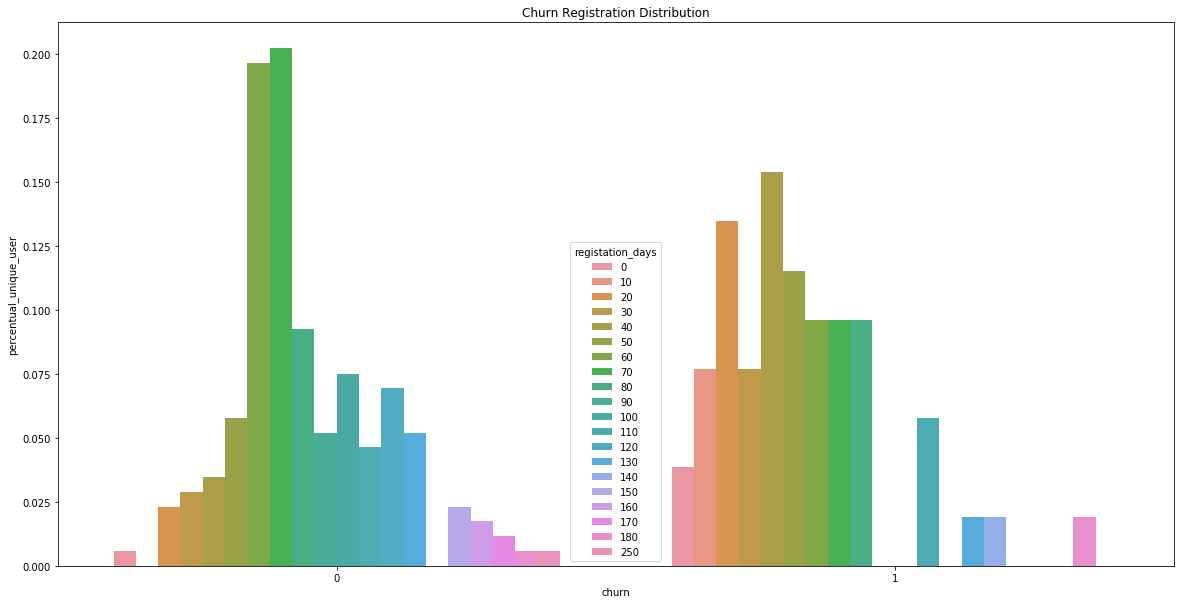

In [89]:
plt.figure(figsize = (20, 10)) 
plt.title('Churn Registration Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'registation_days', data = df_churn_registration_distribution)
plt.show()

The majority of no churn users are registerd from 60 days while is seems that churn users perform the Cancellation before reacheing that period.

For the weekly activity measure let's begin with an example: let's consider again **userId** 124 for no churn users and 51 for churn users:

In [90]:
spark.sql('''
    SELECT UPD.userId
        --, UPD.page
        --, L0.max_datetime
        , COUNT(UPD.userId) AS count_page_week        
    FROM user_page_datetime UPD
    INNER JOIN 
    (
        SELECT userId
            , MAX(datetime_page) AS max_datetime
        FROM user_page_datetime
        GROUP BY userId
    ) L0
        ON UPD.userId = L0.userId
    WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 7)
        AND UPD.userId = 124
        OR UPD.userId = 51
   GROUP BY UPD.userId
    '''
    ).show()

+------+---------------+
|userId|count_page_week|
+------+---------------+
|   124|            301|
|    51|           2464|
+------+---------------+



In [91]:
user_last_weeks_activity = spark.sql('''
    SELECT W1.userId
        , W8.count_page_week AS count_page_last_week_8
        , W7.count_page_week AS count_page_last_week_7
        , W6.count_page_week AS count_page_last_week_6
        , W5.count_page_week AS count_page_last_week_5
        , W4.count_page_week AS count_page_last_week_4
        , W3.count_page_week AS count_page_last_week_3 
        , W2.count_page_week AS count_page_last_week_2        
        , W1.count_page_week AS count_page_last_week_1
    FROM
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 7)
        GROUP BY UPD.userId
    ) W1
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 14)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 7)
        GROUP BY UPD.userId
    ) W2
        ON W1.userId = W2.userId
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 21)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 14)
        GROUP BY UPD.userId
    ) W3
        ON W2.userId = W3.userId    
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 28)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 21)
        GROUP BY UPD.userId
    ) W4
        ON W3.userId = W4.userId  
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 35)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 28)
        GROUP BY UPD.userId
    ) W5
        ON W4.userId = W5.userId  
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 42)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 35)
        GROUP BY UPD.userId
    ) W6
        ON W5.userId = W6.userId   
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 49)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 42)
        GROUP BY UPD.userId
    ) W7
        ON W6.userId = W7.userId 
    INNER JOIN 
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 56)
            AND UPD.datetime_page < DATE_SUB(L0.max_datetime, 49)
        GROUP BY UPD.userId
    ) W8
        ON W7.userId = W8.userId 
    '''
    )

user_last_weeks_activity.createOrReplaceTempView('user_last_weeks_activity')

In [92]:
spark.sql('''
    SELECT *
    FROM user_last_weeks_activity
    '''
    ).show()

+------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|userId|count_page_last_week_8|count_page_last_week_7|count_page_last_week_6|count_page_last_week_5|count_page_last_week_4|count_page_last_week_3|count_page_last_week_2|count_page_last_week_1|
+------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|   124|                   417|                   515|                   210|                   800|                   432|                  1266|                   208|                   301|
|300017|                   725|                   590|                   443|                   373|                   943|                   264|                   370|                   399|
|    42|                   708|    

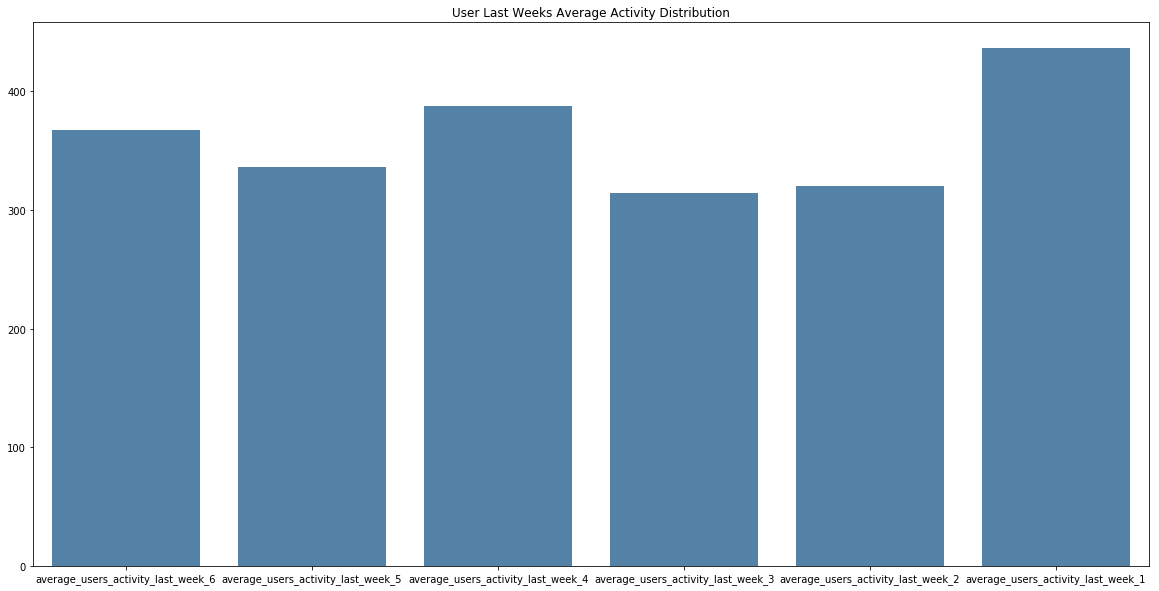

In [93]:
df_user_last_weeks_activity_distribution = spark.sql('''
    SELECT /*AVG(count_page_last_week_8) AS average_users_activity_last_week_8
        , AVG(count_page_last_week_7) AS average_users_activity_last_week_7
        ,*/ AVG(count_page_last_week_6) AS average_users_activity_last_week_6
        , AVG(count_page_last_week_5) AS average_users_activity_last_week_5
        , AVG(count_page_last_week_4) AS average_users_activity_last_week_4
        , AVG(count_page_last_week_3) AS average_users_activity_last_week_3
        , AVG(count_page_last_week_2) AS average_users_activity_last_week_2
        , AVG(count_page_last_week_1) AS average_users_activity_last_week_1
    FROM user_last_weeks_activity
    '''
    ).toPandas()

plt.figure(figsize = (20, 10)) 
plt.title('User Last Weeks Average Activity Distribution')
sns.barplot(data = df_user_last_weeks_activity_distribution, color = 'steelblue')
plt.show()

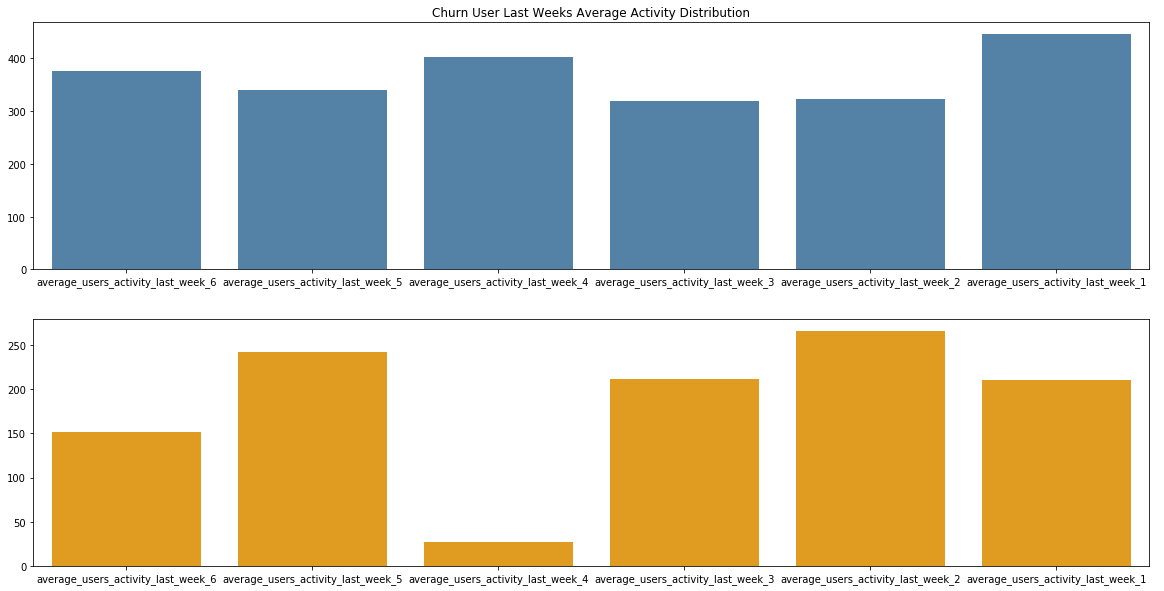

In [94]:
df_no_churn_user_last_weeks_activity_distribution = spark.sql('''
    SELECT /*AVG(count_page_last_week_8) AS average_users_activity_last_week_8
        , AVG(count_page_last_week_7) AS average_users_activity_last_week_7
        ,*/ AVG(count_page_last_week_6) AS average_users_activity_last_week_6
        , AVG(count_page_last_week_5) AS average_users_activity_last_week_5
        , AVG(count_page_last_week_4) AS average_users_activity_last_week_4
        , AVG(count_page_last_week_3) AS average_users_activity_last_week_3
        , AVG(count_page_last_week_2) AS average_users_activity_last_week_2
        , AVG(count_page_last_week_1) AS average_users_activity_last_week_1
    FROM user_last_weeks_activity
    WHERE userId IN (SELECT DISTINCT userId FROM no_churned_clean_user_log)
    '''
    ).toPandas()

df_churn_user_last_weeks_activity_distribution = spark.sql('''
    SELECT /*AVG(count_page_last_week_8) AS average_users_activity_last_week_8
        , AVG(count_page_last_week_7) AS average_users_activity_last_week_7
        ,*/ AVG(count_page_last_week_6) AS average_users_activity_last_week_6
        , AVG(count_page_last_week_5) AS average_users_activity_last_week_5
        , AVG(count_page_last_week_4) AS average_users_activity_last_week_4
        , AVG(count_page_last_week_3) AS average_users_activity_last_week_3
        , AVG(count_page_last_week_2) AS average_users_activity_last_week_2
        , AVG(count_page_last_week_1) AS average_users_activity_last_week_1
    FROM user_last_weeks_activity
    WHERE userId IN (SELECT DISTINCT userId FROM churned_clean_user_log)
    '''
    ).toPandas()

fig = plt.figure(figsize = (20, 10))
plt.title('Churn User Last Weeks Average Activity Distribution')
plt.axis('off')
ax1 = fig.add_subplot(2, 1, 1)
sns.barplot(data = df_no_churn_user_last_weeks_activity_distribution, color = 'steelblue')
ax2 = fig.add_subplot(2, 1, 2)
sns.barplot(data = df_churn_user_last_weeks_activity_distribution, color = 'orange')
plt.show()

As we can see churned user on avarage are less active in the last week before Cancellation

Now let's analyze the number of artisted listened from the users:

In [95]:
df_artist_distribution = spark.sql('''
    SELECT unique_artist_count
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , CAST(COUNT(DISTINCT(artist))  / 100 AS INT) * 100 AS unique_artist_count
        FROM clean_user_log
        GROUP BY userId
    )
    GROUP BY unique_artist_count
    '''
    ).toPandas()

df_artist_distribution

,unique_artist_count,unique_user_count
0,1700,3
1,2200,1
2,1500,3
3,300,15
4,3500,1
5,1300,10
6,1100,14
7,500,19
8,1800,2
9,1600,4


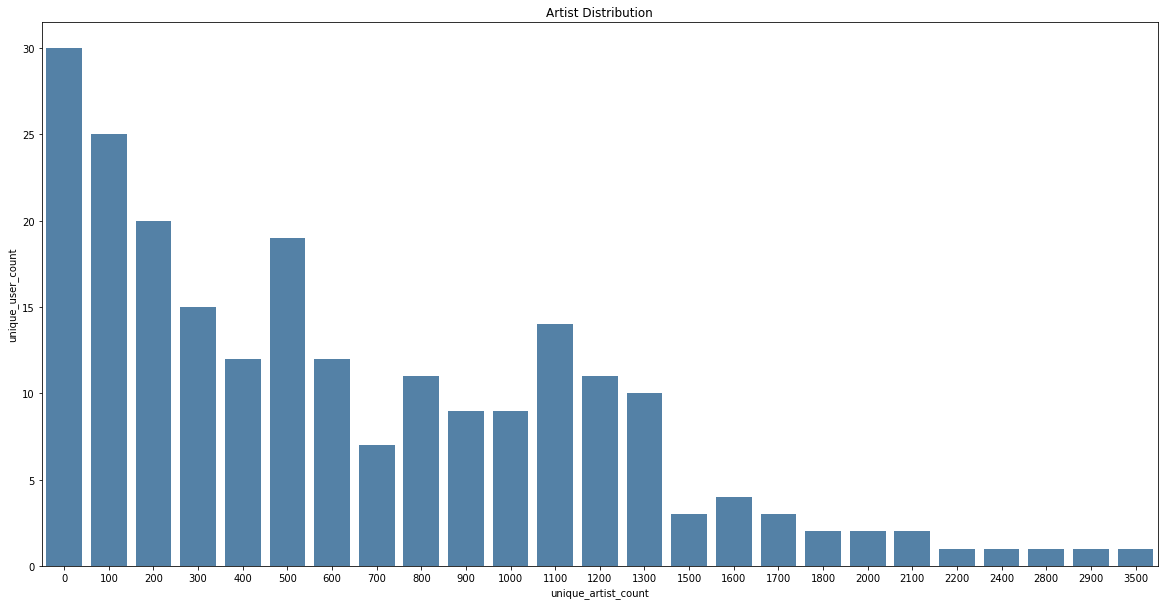

In [96]:
plt.figure(figsize = (20, 10)) 
plt.title('Artist Distribution')
sns.barplot(x = 'unique_artist_count', y = 'unique_user_count', data = df_artist_distribution, color = 'steelblue')
plt.show()

In [97]:
df_churn_artist_distribution = spark.sql('''
    SELECT 0 AS churn
        , unique_artist_count
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , CAST(COUNT(DISTINCT(artist))  / 100 AS INT) * 100 AS unique_artist_count
        FROM no_churned_clean_user_log
        GROUP BY userId
    )
    GROUP BY unique_artist_count
    
    UNION ALL
    
    SELECT 1 AS churn
        , unique_artist_count
        , COUNT(DISTINCT(userId)) AS unique_user_count
    FROM 
    (
        SELECT userId
            , CAST(COUNT(DISTINCT(artist))  / 100 AS INT) * 100 AS unique_artist_count
        FROM churned_clean_user_log
        GROUP BY userId
    )
    GROUP BY unique_artist_count
    '''
    ).toPandas()

df_churn_artist_distribution

,churn,unique_artist_count,unique_user_count
0,0,1700,2
1,0,2200,1
2,0,1500,3
3,0,300,8
4,0,3500,1
5,0,1300,9
6,0,1100,12
7,0,500,16
8,0,1800,1
9,0,1600,4


In [98]:
df_churn_artist_distribution = percentual_unique_user(df_churn_artist_distribution)
df_churn_artist_distribution

,churn,unique_artist_count,unique_user_count,percentual_unique_user
0,0,1700,2,0.011561
1,0,2200,1,0.005780
2,0,1500,3,0.017341
3,0,300,8,0.046243
4,0,3500,1,0.005780
5,0,1300,9,0.052023
6,0,1100,12,0.069364
7,0,500,16,0.092486
8,0,1800,1,0.005780
9,0,1600,4,0.023121


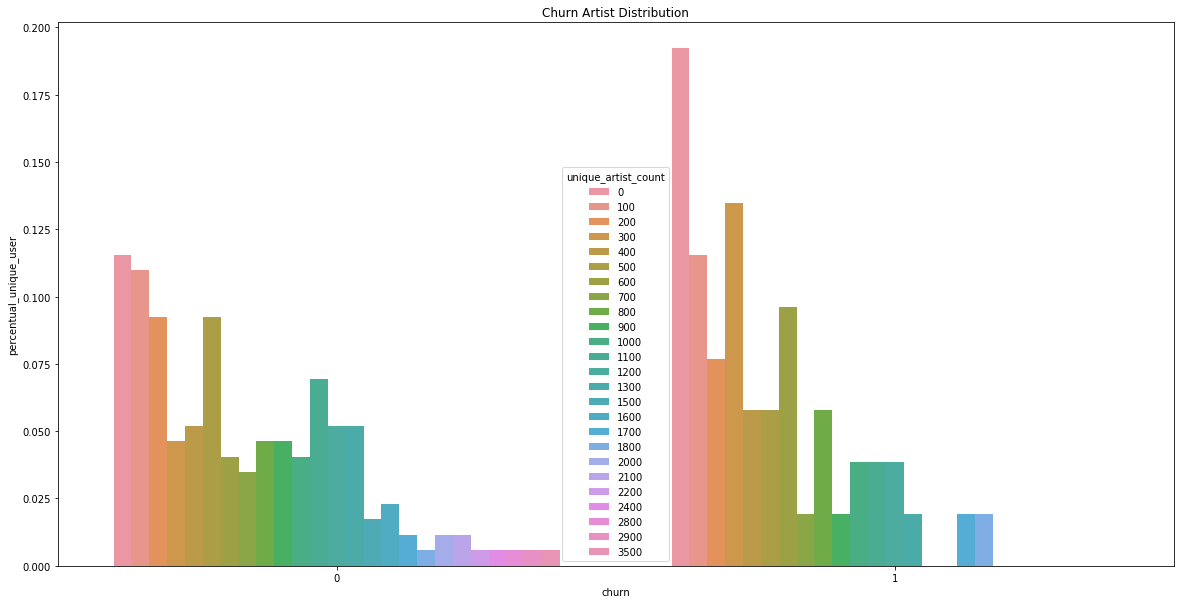

In [99]:
plt.figure(figsize = (20, 10)) 
plt.title('Churn Artist Distribution')
sns.barplot(x = 'churn', y = 'percentual_unique_user', hue = 'unique_artist_count', data = df_churn_artist_distribution)
plt.show()

The user-artist distribution is left skewed of course but for churn users the skewed is more steep meaning they listed to less artists. The final step is to combine all the features together:
- 1 Create a view for each new engineered feature
- 2 Join all the feasture usgin userId to obtain the datasets to perform the training on

In [100]:
registration_distribution_feature = spark.sql('''
    SELECT userId
        , DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) AS registration_days
    FROM user_page_datetime
    GROUP BY userId 
    '''
    )

registration_distribution_feature.createOrReplaceTempView('registration_distribution_feature')

In [101]:
last_week_distribution_feature = spark.sql('''
    SELECT W1.userId
        , W1.count_page_week AS count_page_last_week
    FROM
    (
        SELECT UPD.userId
            , COUNT(UPD.userId) AS count_page_week        
        FROM user_page_datetime UPD
        INNER JOIN 
        (
            SELECT userId
                , MAX(datetime_page) AS max_datetime
            FROM user_page_datetime
            GROUP BY userId
        ) L0
            ON UPD.userId = L0.userId
        WHERE UPD.datetime_page >= DATE_SUB(L0.max_datetime, 7)
        GROUP BY UPD.userId
    ) W1
    '''
    )

last_week_distribution_feature.createOrReplaceTempView('last_week_distribution_feature')

In [102]:
artist_distribution_feature = spark.sql('''
    SELECT userId
        , COUNT(DISTINCT(artist)) AS unique_artist_count
    FROM clean_user_log
    GROUP BY userId
    '''
    )

artist_distribution_feature.createOrReplaceTempView('artist_distribution_feature')

In [103]:
engineered_feature = spark.sql('''
    SELECT BEF.userId
        , BEF.churn
        , BEF.gender_F
        , BEF.gender_M
        , BEF.level_free
        , BEF.level_paid
        --, BEF.page_Cancel
        , BEF.page_Submit_Downgrade
        , BEF.page_Thumbs_Down
        , BEF.page_Home
        , BEF.page_Downgrade
        , BEF.page_Roll_Advert
        , BEF.page_Logout
        , BEF.page_Save_Settings
        --, BEF.page_Cancellation_Confirmation
        , BEF.page_About
        , BEF.page_Settings
        , BEF.page_Add_to_Playlist
        , BEF.page_Add_Friend
        , BEF.page_NextSong
        , BEF.page_Thumbs_Up
        , BEF.page_Help
        , BEF.page_Upgrade
        , BEF.page_Error
        , BEF.page_Submit_Upgrade
        , BEF.total_visited_page  
        , RDF.registration_days
        , LWDF.count_page_last_week
        , ADF.unique_artist_count
    FROM base_engineered_feature BEF
    INNER JOIN registration_distribution_feature RDF
        ON BEF.userId = RDF.userId
    INNER JOIN last_week_distribution_feature LWDF
        ON BEF.userId = LWDF.userId
    INNER JOIN artist_distribution_feature ADF
        ON BEF.userId = ADF.userId
    '''
    )

engineered_feature.persist()
engineered_feature.show()

+------+-----+--------+--------+----------+----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+------------------+-----------------+--------------------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|total_visited_page|registration_days|count_page_last_week|unique_artist_count|
+------+-----+--------+--------+----------+----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+----------+-------------+--------------------+--------

In [104]:
engineered_feature

DataFrame[userId: string, churn: int, gender_F: int, gender_M: int, level_free: int, level_paid: int, page_Submit_Downgrade: bigint, page_Thumbs_Down: bigint, page_Home: bigint, page_Downgrade: bigint, page_Roll_Advert: bigint, page_Logout: bigint, page_Save_Settings: bigint, page_About: bigint, page_Settings: bigint, page_Add_to_Playlist: bigint, page_Add_Friend: bigint, page_NextSong: bigint, page_Thumbs_Up: bigint, page_Help: bigint, page_Upgrade: bigint, page_Error: bigint, page_Submit_Upgrade: bigint, total_visited_page: bigint, registration_days: int, count_page_last_week: bigint, unique_artist_count: bigint]

In [105]:
engineered_feature.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [106]:
ENGINEERED_DATA_FILENAME = 'engineered_data.json'

#os.remove(ENGINEERED_DATA_FILENAME)
shutil.rmtree(ENGINEERED_DATA_FILENAME)

engineered_feature.write.save(ENGINEERED_DATA_FILENAME, format = 'json')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [107]:
df = spark.read.json(ENGINEERED_DATA_FILENAME)
df.persist()
df.head()

Row(churn=0, count_page_last_week=407, gender_F=1, gender_M=0, level_free=1, level_paid=1, page_About=0, page_Add_Friend=19, page_Add_to_Playlist=23, page_Downgrade=10, page_Error=2, page_Help=6, page_Home=66, page_Logout=19, page_NextSong=942, page_Roll_Advert=86, page_Save_Settings=2, page_Settings=11, page_Submit_Downgrade=2, page_Submit_Upgrade=3, page_Thumbs_Down=11, page_Thumbs_Up=35, page_Upgrade=8, registration_days=173, total_visited_page=1245, unique_artist_count=733, userId='100004')

In [108]:
df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [109]:
colonne = df.columns[1:-1]
colonne

['count_page_last_week',
 'gender_F',
 'gender_M',
 'level_free',
 'level_paid',
 'page_About',
 'page_Add_Friend',
 'page_Add_to_Playlist',
 'page_Downgrade',
 'page_Error',
 'page_Help',
 'page_Home',
 'page_Logout',
 'page_NextSong',
 'page_Roll_Advert',
 'page_Save_Settings',
 'page_Settings',
 'page_Submit_Downgrade',
 'page_Submit_Upgrade',
 'page_Thumbs_Down',
 'page_Thumbs_Up',
 'page_Upgrade',
 'registration_days',
 'total_visited_page',
 'unique_artist_count']

In [110]:
print(len(colonne))

25


In [111]:
# vector assembler

assembler = VectorAssembler(inputCols = colonne, outputCol = 'features')
data = assembler.transform(df)
data.show(1)

+-----+--------------------+--------+--------+----------+----------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+-----------------+------------------+-------------------+------+--------------------+
|churn|count_page_last_week|gender_F|gender_M|level_free|level_paid|page_About|page_Add_Friend|page_Add_to_Playlist|page_Downgrade|page_Error|page_Help|page_Home|page_Logout|page_NextSong|page_Roll_Advert|page_Save_Settings|page_Settings|page_Submit_Downgrade|page_Submit_Upgrade|page_Thumbs_Down|page_Thumbs_Up|page_Upgrade|registration_days|total_visited_page|unique_artist_count|userId|            features|
+-----+--------------------+--------+--------+----------+----------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+----

In [112]:
# standard scaler

scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features', withStd = True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
data.show(1)

+-----+--------------------+--------+--------+----------+----------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+-----------------+------------------+-------------------+------+--------------------+--------------------+
|churn|count_page_last_week|gender_F|gender_M|level_free|level_paid|page_About|page_Add_Friend|page_Add_to_Playlist|page_Downgrade|page_Error|page_Help|page_Home|page_Logout|page_NextSong|page_Roll_Advert|page_Save_Settings|page_Settings|page_Submit_Downgrade|page_Submit_Upgrade|page_Thumbs_Down|page_Thumbs_Up|page_Upgrade|registration_days|total_visited_page|unique_artist_count|userId|            features|     scaled_features|
+-----+--------------------+--------+--------+----------+----------+----------+---------------+--------------------+--------------+-----

In [113]:
data = data.select(data.churn.alias('label'), data.scaled_features.alias('features'))
data.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[1.49779530831110...|
+-----+--------------------+
only showing top 1 row



In [114]:
# train test validation split

train, rest = data.randomSplit([0.6, 0.4], seed = 42)
validation, test = rest.randomSplit([0.5, 0.5], seed = 42)

## Naive Predictor

The the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. 
As already said looking at the distribution of the data it's clear most users do not churn. Therefore a model that always predicts `'0'` (i.e. the user do not visit page `Cancellation Confirmation`) will generally be right.

### Confusion Matrix, Accuracy, Precision, Recall

A **Confusion Matrix**  is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

|       -      |        -        |    Predicted Label   |           -          |
|--------------|-----------------|----------------------|----------------------| 
|       -      |        -        |          0           |           1          |
| Actual Label |        0        | True Negatives (TN)  | False Positives (FP) |
|       -      |        1        | False Negatives (FN) | True Positives (TP)  |

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points):

`Accuracy = (True Positives + True Negative) / (True Positives + False Positives + True Negatives + False Negatives)`

**Precision** tells us what proportion of the correct prediction, actually were correct. It is a ratio of true positives to all positives, in other words it is the ratio of:

`Precision = True Positives / (True Positives + False Positives)`

**Recall (Sensitivity)** tells us what proportion of prediction that actually were correct were classified by us as correct.
It is a ratio of true positives to all the prediction that were actually positive, in other words it is the ratio of:

`Recall = True Positives / (True Positives + False Negative)`

**F-beta score** is a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In [115]:
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')

prediction_all_0 = test.withColumn('prediction', lit(0.0))

print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(prediction_all_0, {evaluator.metricName: 'accuracy'})))
print('F-1 Score:{}'.format(evaluator.evaluate(prediction_all_0, {evaluator.metricName: 'f1'})))

Test set metrics:
Accuracy: 0.7209302325581395
F-1 Score:0.6040226272784412


The naive model which labels all users with churn = 0 does a good job on test set, with **Accuracy** of 81.2% and **F1 score** of 0.7284

Let's compare the results of 3 models:
- **Logistic Regression**
- **Gradient Boosted Trees**
- **Support Vector Machine**

## Logistic Regression

In [116]:
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

# build paramGrid
param_grid = ParamGridBuilder().build()

In [117]:
# initialize classifier
logistic_regression = LogisticRegression(maxIter = 10)

crossvalidator_logistic_regression = CrossValidator(estimator = logistic_regression, 
                                                    evaluator = f1_evaluator,
                                                    estimatorParamMaps = param_grid,
                                                    numFolds = 3)

In [118]:
%%time
cv_logistic_regression_model = crossvalidator_logistic_regression.fit(train)

CPU times: user 126 ms, sys: 10.1 ms, total: 136 ms
Wall time: 10 s


In [119]:
results_logistic_regression = cv_logistic_regression_model.transform(test)

print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_logistic_regression, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_logistic_regression, {evaluator.metricName: 'f1'})))

Logistic Regression Metrics:
Accuracy: 0.8372093023255814
F-1 Score: 0.8119510696088343


In [120]:
logistic_regression_best_model = cv_logistic_regression_model.bestModel
logistic_regression_best_model.extractParamMap()

{Param(parent='LogisticRegression_acbbda91a0c3', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_acbbda91a0c3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_acbbda91a0c3', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_acbbda91a0c3', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_acbbda91a0c3', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_acbbda91a0c3', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_acbbda91a0c3', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [121]:
results_best_logistic_regression = logistic_regression_best_model.transform(validation)

print('Best Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_best_logistic_regression, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_best_logistic_regression, {evaluator.metricName: 'f1'})))

Best Logistic Regression Metrics:
Accuracy: 0.7291666666666666
F-1 Score: 0.7229151154132538


## Gradient Boosted Trees

In [122]:
# initialize classifier
gradient_boosted_trees = GBTClassifier(maxIter = 10, seed = 42)

crossvalidator_gradient_boosted_trees = CrossValidator(estimator = gradient_boosted_trees,
                                                       evaluator = f1_evaluator,
                                                       estimatorParamMaps = param_grid,
                                                       numFolds = 3)

In [123]:
%%time
cv_gradient_boosted_trees_model = crossvalidator_gradient_boosted_trees.fit(train)

CPU times: user 185 ms, sys: 30.4 ms, total: 215 ms
Wall time: 38 s


In [124]:
results_gradient_boosted_trees = cv_gradient_boosted_trees_model.transform(test)

print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gradient_boosted_trees, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_gradient_boosted_trees, {evaluator.metricName: 'f1'})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7209302325581395
F-1 Score: 0.7270125223613595


In [125]:
gradient_boosted_trees_best_model = cv_gradient_boosted_trees_model.bestModel
gradient_boosted_trees_best_model.extractParamMap()

{Param(parent='GBTClassifier_07edb17b2066', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_07edb17b2066', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_07edb17b2066', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_07edb17b2066', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_07edb17b2066', name='labelCol', doc='label column name'): 'la

In [126]:
results_best_gradient_boosted_trees = gradient_boosted_trees_best_model.transform(validation)

print('Best Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_best_gradient_boosted_trees, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_best_gradient_boosted_trees, {evaluator.metricName: 'f1'})))

Best Gradient Boosted Trees Metrics:
Accuracy: 0.6666666666666666
F-1 Score: 0.6944444444444444


Text(0.5,0,'Importance Score')

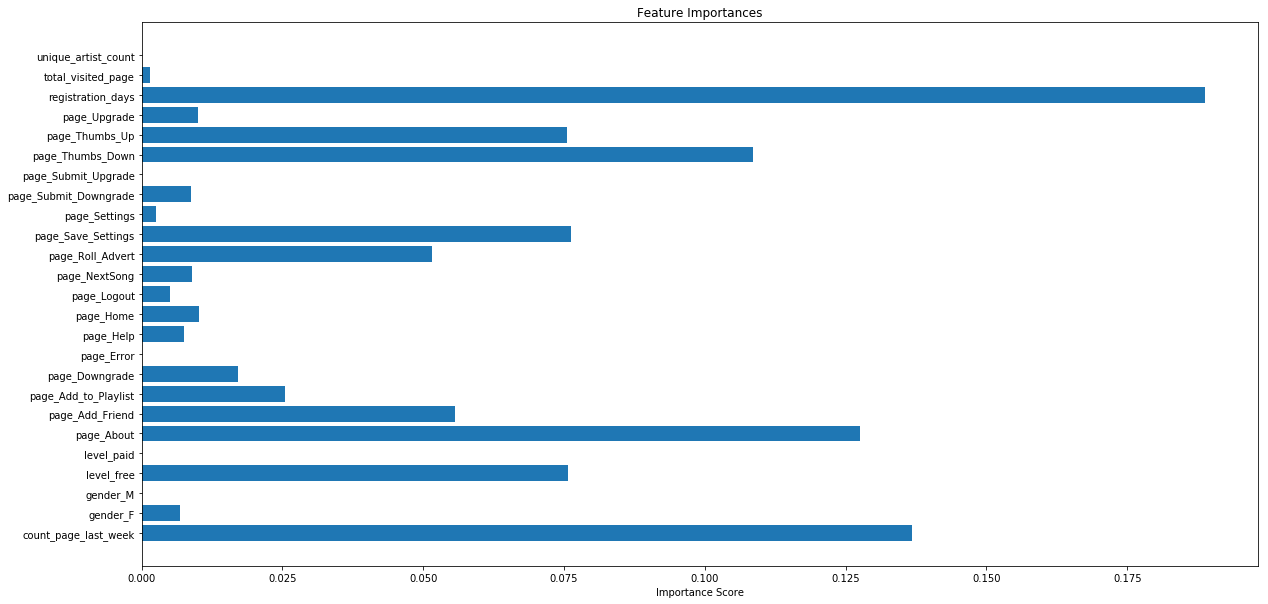

In [127]:
feature_importance = gradient_boosted_trees_best_model.featureImportances
y_index = np.arange(len(colonne))
plt.figure(figsize = (20, 10)) 
plt.title('Feature Importances')
plt.barh(y_index, feature_importance, align = 'center')
plt.yticks(y_index, colonne)
plt.xlabel('Importance Score')

## Support Vector Machine

In [128]:
# initialize classifier
linear_svc = LinearSVC(maxIter = 10)

crossvalidator_linear_svc = CrossValidator(estimator = linear_svc,
                                           evaluator = f1_evaluator,
                                           estimatorParamMaps = param_grid,
                                           numFolds = 3)

In [129]:
%%time
cv_linear_svc_model = crossvalidator_linear_svc.fit(train)

CPU times: user 111 ms, sys: 9.12 ms, total: 120 ms
Wall time: 9.73 s


In [130]:
results_linear_svc = cv_linear_svc_model.transform(test)

print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_linear_svc, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_linear_svc, {evaluator.metricName: 'f1'})))

Logistic Regression Metrics:
Accuracy: 0.7209302325581395
F-1 Score: 0.6040226272784412


In [131]:
linear_svc_best_model = cv_linear_svc_model.bestModel
linear_svc_best_model.extractParamMap()

{Param(parent='LinearSVC_dfe280502685', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearSVC_dfe280502685', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearSVC_dfe280502685', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearSVC_dfe280502685', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearSVC_dfe280502685', name='maxIter', doc='maximum number of iterations (>= 0)'): 10,
 Param(parent='LinearSVC_dfe280502685', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='LinearSVC_dfe280502685', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='LinearSVC_dfe280502685', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LinearSVC_dfe280502685', name='standardization', doc='whether to standardize the training features before fitting the

In [132]:
results_best_linear_svc = linear_svc_best_model.transform(validation)

print('Best Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_best_linear_svc, {evaluator.metricName: 'accuracy'})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_best_linear_svc, {evaluator.metricName: 'f1'})))

Best Logistic Regression Metrics:
Accuracy: 0.8125
F-1 Score: 0.728448275862069


## Results

|       Classifier       | Test     |     -     | Validation |     -     |
|------------------------|----------|-----------|------------|-----------|
|           -            | Accuracy | F-1 Score | Accuracy   | F-1 Score |
| Naive Predictor        |  0.7209  |   0.6040  |      -     |     -     |
| Logistic Regression    |  0.8372  |   0.8218  |    0.7916  |   0.7546  |
| Gradient Boosted Trees |  0.8139  |   0.8084  |    0.7291  |   0.7338  |
| Support Vector Machine |  0.7209  |   0.6040  |    0.7916  |   0.6996  |

So **Logistic Regression** has the best results wit a F-1 Score of 0.8218 on test dataset and 0.7546 on validation dataset.
From the `featureImportances` from the **Gradient Boosted Tree** model we can see that the engineered feature `registration_days` and `count_page_last_week` perform pretty well for predicting the churn of users

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.